<a href="https://colab.research.google.com/github/DarshanSuresh/Academic_Stress_Levels_in_UG_Students_using_ML_Models/blob/main/Meditation_and_Academic_Stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre vs Post Meditation Stress Comparison

In [2]:
# Pre vs Post Meditation Stress Comparison

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Step 1: Load the CSV File
file_path = "/content/merge.csv"
#df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')
df = pd.read_csv(file_path, skiprows=3, encoding='utf-8', on_bad_lines='skip')

# Step 2: Select Relevant Columns
cols = [
    "A. Enter your Gender",
    "B. Frequency of Meditation:",
    "PRE1. I feel stressed about academic deadlines and exams.",
    "POST1. I feel stressed about academic deadlines and exams."
]
data = df[cols].copy()

# Step 3: Clean the Data
data = data.dropna()
data.rename(columns={
    "B. Frequency of Meditation:": "Meditation_Frequency",
    "PRE1. I feel stressed about academic deadlines and exams.": "Stress_Pre",
    "POST1. I feel stressed about academic deadlines and exams.": "Stress_Post"
}, inplace=True)

# Step 4: Encode Stress Levels (if they are Likert-scale words)
# Example: “Strongly Agree” = 5, “Agree” = 4, “Neutral” = 3, etc.
mapping = {
    "Strongly Agree": 5,
    "Agree": 4,
    "Neutral": 3,
    "Disagree": 2,
    "Strongly Disagree": 1
}

data["Stress_Pre"] = data["Stress_Pre"].replace(mapping)
data["Stress_Post"] = data["Stress_Post"].replace(mapping)

# Step 5: Compute Average Reduction in Stress
data["Stress_Change"] = data["Stress_Post"] - data["Stress_Pre"]
avg_change = data["Stress_Change"].mean()

print("🔹 Average Stress Change (Post - Pre):", round(avg_change, 2))
if avg_change < 0:
    print("🧘 Meditation seems to reduce stress on average.")
elif avg_change > 0:
    print("⚠️ Stress increased slightly post meditation.")
else:
    print("ℹ️ No significant change in stress levels observed.")

🔹 Average Stress Change (Post - Pre): -0.31
🧘 Meditation seems to reduce stress on average.


### Comment

#### Trail 01

🔹 Average Stress Change (Post - Pre): -0.31
🧘 Meditation seems to reduce stress on average.

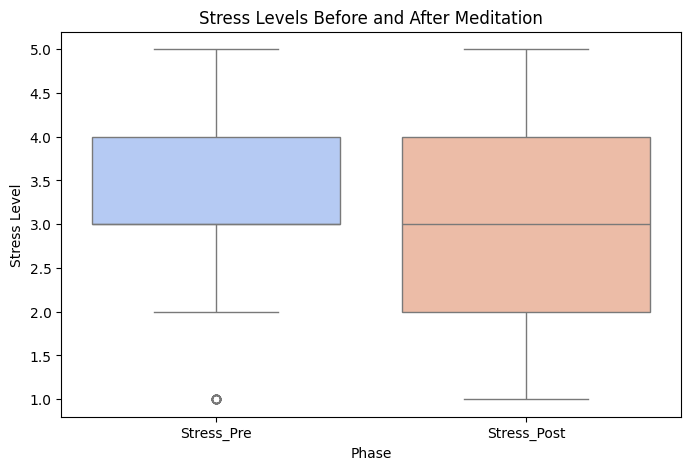

In [4]:
# Visualization — Before vs After Meditation
plt.figure(figsize=(8,5))
sns.boxplot(data=pd.melt(data[["Stress_Pre", "Stress_Post"]], var_name="Phase", value_name="Stress Level"),
            x="Phase", y="Stress Level", palette="coolwarm")
plt.title("Stress Levels Before and After Meditation")
plt.show()


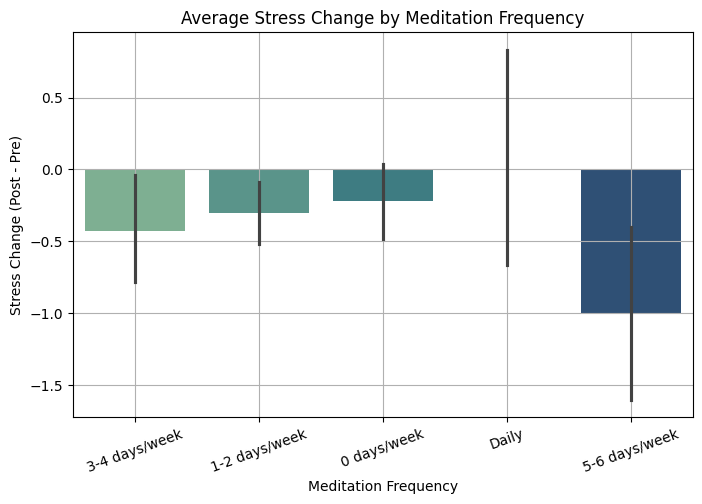

In [5]:
# Step 7: Visualization — Stress Reduction by Meditation Frequency
plt.figure(figsize=(8,5))
sns.barplot(data=data, x="Meditation_Frequency", y="Stress_Change", palette="crest")
plt.xticks(rotation=20)
plt.title("Average Stress Change by Meditation Frequency")
plt.ylabel("Stress Change (Post - Pre)")
plt.xlabel("Meditation Frequency")
plt.grid(True)
plt.show()


In [6]:
# Step 8: Insight Summary
pre_mean = data["Stress_Pre"].mean()
post_mean = data["Stress_Post"].mean()
print(f"\n📊 Average Pre-stress: {pre_mean:.2f}")
print(f"📊 Average Post-stress: {post_mean:.2f}")
print(f"📉 Reduction: {pre_mean - post_mean:.2f}")



📊 Average Pre-stress: 3.34
📊 Average Post-stress: 3.03
📉 Reduction: 0.31


### Comments

#### Trail 01 - original (176)

📊 Average Pre-stress: 3.24
📊 Average Post-stress: 2.93
📉 Reduction: 0.30

#### Trail 02 - merge (684)


📊 Average Pre-stress: 3.34
📊 Average Post-stress: 3.03
📉 Reduction: 0.31

# Deep meditation


In [7]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, classification_report, mean_squared_error, r2_score, mean_absolute_error)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

## Loading CSV, PRE/POST, Numeric Treatment

In [8]:
# file_path = "/content/Research Paper Data Collection (UG) - Meditation and Academic Stress - Sheet1 (2).csv"
file_path = "/content/merge.csv"
assert os.path.exists(file_path), f"File not found: {file_path}"

# 1) Load the CSV
df = pd.read_csv(file_path, skiprows=3, encoding='utf-8', on_bad_lines='skip')
#df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')
print("Loaded rows,cols:", df.shape)
print("Columns:", df.columns.tolist())

# 2) Detect PRE/POST item columns
pre_cols = [c for c in df.columns if c.strip().upper().startswith('PRE')]
post_cols = [c for c in df.columns if c.strip().upper().startswith('POST')]

# safety fallback if detection is different
if len(pre_cols) < 7:
    pre_cols = [c for c in df.columns if 'PRE' in c.upper()][:7]
if len(post_cols) < 7:
    post_cols = [c for c in df.columns if 'POST' in c.upper()][:7]

print("Detected PRE cols:", pre_cols)
print("Detected POST cols:", post_cols)

# 3) Create numeric treatment & outcome variables
# map frequency text -> numeric days/week (robust)
def freq_to_days(val):
    if pd.isna(val):
        return np.nan
    s = str(val).lower()
    if 'daily' in s or 'everyday' in s:
        return 7.0
    if '3-4' in s or '3 - 4' in s or '3 to 4' in s:
        return 3.5
    if '1-2' in s or '1 - 2' in s or '1 to 2' in s:
        return 1.5
    if 'none' in s or '0' in s:
        return 0.0
    if 'rare' in s:
        return 0.3
    if 'occasional' in s:
        return 1.5
    if 'frequent' in s:
        return 4.0
    if 'weekly' in s:
        m = re.search(r'(\d+)', s)
        return float(m.group(1)) if m else 1.0
    m = re.search(r'(\d+(\.\d+)?)', s)
    if m:
        return float(m.group(1))
    return np.nan

freq_col = "B. Frequency of Meditation:"
if freq_col not in df.columns:
    freq_candidates = [c for c in df.columns if 'frequency' in c.lower() or 'freq' in c.lower()]
    freq_col = freq_candidates[0] if freq_candidates else None

if freq_col:
    df['meditation_freq_days'] = df[freq_col].apply(freq_to_days)
else:
    df['meditation_freq_days'] = np.nan

# map average duration text -> minutes numeric
dur_col = "B. Average Duration of each meditation session:"
def duration_to_min(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    if '<5' in s or 'less than 5' in s: return 2.5
    if '5-15' in s or '5 - 15' in s: return 10
    if '15-30' in s: return 22.5
    if '30-60' in s: return 45
    if '>60' in s or 'more than 60' in s: return 75
    m = re.search(r'(\d+)', s)
    return float(m.group(1)) if m else np.nan

if dur_col in df.columns:
    df['meditation_dur_min'] = df[dur_col].apply(duration_to_min)
else:
    df['meditation_dur_min'] = np.nan

# Build PRE/POST scores (sum of items)
if len(pre_cols) >= 1 and len(post_cols) >= 1:
    # convert to numeric where possible
    df[pre_cols] = df[pre_cols].apply(pd.to_numeric, errors='coerce')
    df[post_cols] = df[post_cols].apply(pd.to_numeric, errors='coerce')
    df['PRE_score'] = df[pre_cols].sum(axis=1)
    df['POST_score'] = df[post_cols].sum(axis=1)
    df['delta_score'] = df['POST_score'] - df['PRE_score']   # negative = reduced stress
else:
    raise RuntimeError("Could not find PRE/POST columns. Please check column names.")

# Target (classification): did stress *decrease* after meditation? improved = 1 if POST < PRE
df['improved'] = (df['POST_score'] < df['PRE_score']).astype(int)

# Inspect class balance
print("Improved counts:\n", df['improved'].value_counts(dropna=False))


Loaded rows,cols: (684, 49)
Columns: ['Submission ID', 'Respondent ID', 'Submitted at', 'A. Enter your age', 'A. Enter your Gender', 'A. Program of Study', 'A. Semester', 'A. Program/Course', 'Program Other Field', 'A. Prior Meditation Experience:', 'B. Frequency of Meditation:', 'B. Average Duration of each meditation session:', 'B. Type of Meditation practiced:', 'B. Would you do meditation voluntarily? By yourself ', 'PRE1. I feel stressed about academic deadlines and exams.', 'PRE2. I struggle to concentrate on studies due to stress.', 'PRE3. Meditation does not help reduce my stress.', 'PRE4. I often feel anxious before tests or assignments.', 'PRE5. I can manage multiple academic tasks without feeling overwhelmed.', 'PRE6. Stress negatively affects my academic performance.', 'PRE7. I feel calm and focused during study sessions.', 'POST1. I feel stressed about academic deadlines and exams.', 'POST2. I struggle to concentrate on studies due to stress.', 'POST3. Meditation does not 

## Feature selection for modeling

In [9]:
# 4) Feature selection for modeling
# Candidate features:
# - PRE items (7) (important baseline)
# - demographic: age, gender
# - meditation features: meditation_freq_days, meditation_dur_min, type of meditation
# - optional: semester, program
feat_cols = []
# numeric PRE item columns:
feat_cols += [c for c in pre_cols if c in df.columns]
# numeric demographics:
if "A. Enter your age" in df.columns:
    df['age'] = pd.to_numeric(df["A. Enter your age"], errors='coerce')
    feat_cols.append('age')
if "A. Enter your Gender" in df.columns:
    cat_gender = "A. Enter your Gender"
else:
    cat_gender = None
# meditation features
feat_cols += ['meditation_freq_days','meditation_dur_min']
# type of meditation (categorical)
type_col = "B. Type of Meditation practiced:"
cat_cols = []
if type_col in df.columns:
    cat_cols.append(type_col)
if cat_gender:
    cat_cols.append(cat_gender)

# drop rows with missing target or all-important features
model_df = df[feat_cols + cat_cols + ['improved','delta_score','PRE_score','POST_score']].copy()
model_df = model_df.dropna(subset=['improved','PRE_score'])  # require PRE_score & target
print("Rows available for modeling:", len(model_df))

# quick impute for missing numeric features (median)
for c in feat_cols:
    if c in model_df.columns and model_df[c].isna().any():
        model_df[c] = model_df[c].fillna(model_df[c].median())

# For categorical nulls, fill 'Unknown'
for c in cat_cols:
    model_df[c] = model_df[c].fillna('Unknown').astype(str)

Rows available for modeling: 684


## Build preprocessing pipeline

In [10]:
# 5) Build preprocessing pipeline
numeric_features = [c for c in feat_cols if c in model_df.columns and model_df[c].dtype in [np.float64, np.int64, 'float64','int64']]
categorical_features = [c for c in cat_cols if c in model_df.columns]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# helper to extract feature names after ColumnTransformer
def get_feature_names_from_coltransformer(column_transformer):
    # adapted helper
    output_features = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'named_steps') and 'ohe' in trans.named_steps:
            ohe = trans.named_steps['ohe']
            # get feature names from ohe
            categories = ohe.categories_
            for i, col in enumerate(cols):
                for cat in categories[i]:
                    safe = f"{col}__{cat}"
                    output_features.append(safe)
        else:
            # numeric scaler etc -> keep original col names
            for col in cols:
                output_features.append(col)
    return output_features

Numeric features: ['PRE1. I feel stressed about academic deadlines and exams.', 'PRE2. I struggle to concentrate on studies due to stress.', 'PRE3. Meditation does not help reduce my stress.', 'PRE4. I often feel anxious before tests or assignments.', 'PRE5. I can manage multiple academic tasks without feeling overwhelmed.', 'PRE6. Stress negatively affects my academic performance.', 'PRE7. I feel calm and focused during study sessions.', 'age', 'meditation_freq_days', 'meditation_dur_min']
Categorical features: ['B. Type of Meditation practiced:', 'A. Enter your Gender']


### Comments

#### Trail 01

Numeric features: ['PRE1. I feel stressed about academic deadlines and exams.', 'PRE2. I struggle to concentrate on studies due to stress.', 'PRE3. Meditation does not help reduce my stress.', 'PRE4. I often feel anxious before tests or assignments.', 'PRE5. I can manage multiple academic tasks without feeling overwhelmed.', 'PRE6. Stress negatively affects my academic performance.', 'PRE7. I feel calm and focused during study sessions.', 'age', 'meditation_freq_days', 'meditation_dur_min']
Categorical features: ['B. Type of Meditation practiced:', 'A. Enter your Gender']

#### Trail 02 - merge (684)

Numeric features: ['PRE1. I feel stressed about academic deadlines and exams.', 'PRE2. I struggle to concentrate on studies due to stress.', 'PRE3. Meditation does not help reduce my stress.', 'PRE4. I often feel anxious before tests or assignments.', 'PRE5. I can manage multiple academic tasks without feeling overwhelmed.', 'PRE6. Stress negatively affects my academic performance.', 'PRE7. I feel calm and focused during study sessions.', 'age', 'meditation_freq_days', 'meditation_dur_min']
Categorical features: ['B. Type of Meditation practiced:', 'A. Enter your Gender']

## Train/Test split

In [11]:
# 6) Train/test split
X = model_df[numeric_features + categorical_features]
y = model_df['improved']
# stratify to keep class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (547, 12) (137, 12)


### Comments

#### Trail 01

Train/test sizes: (108, 12) (27, 12)

#### Trail 02 - merge (684)

Train/test sizes: (547, 12) (137, 12)

## Classifiers: KNN, SVM, RandomForest (GridSearch)


== Training knn ==
Best params: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Best CV f1: 0.5047619047619047

== Training svc ==
Best params: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best CV f1: 0.5474624694821048

== Training rf ==
Best params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best CV f1: 0.6314108114108115

--- Test results for knn ---
Accuracy: 0.9124087591240876
F1: 0.6470588235294118
ROC AUC: 0.9299719887955182
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       119
           1       0.69      0.61      0.65        18

    accuracy                           0.91       137
   macro avg       0.81      0.78      0.80       137
weighted avg       0.91      0.91      0.91       137



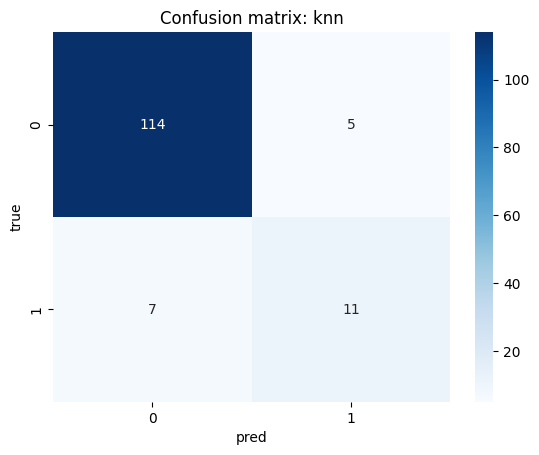

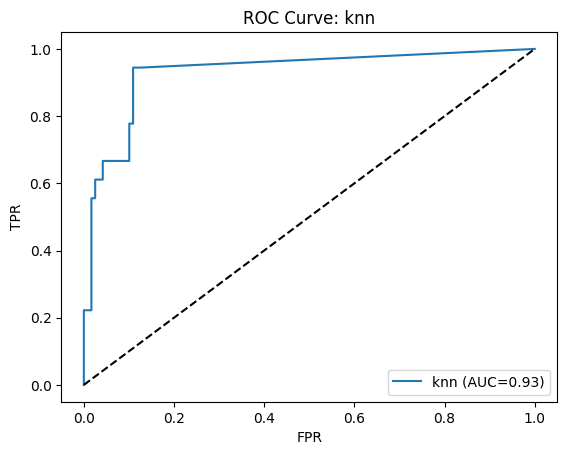


--- Test results for svc ---
Accuracy: 0.8905109489051095
F1: 0.5161290322580645
ROC AUC: 0.7521008403361346
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       119
           1       0.62      0.44      0.52        18

    accuracy                           0.89       137
   macro avg       0.77      0.70      0.73       137
weighted avg       0.88      0.89      0.88       137



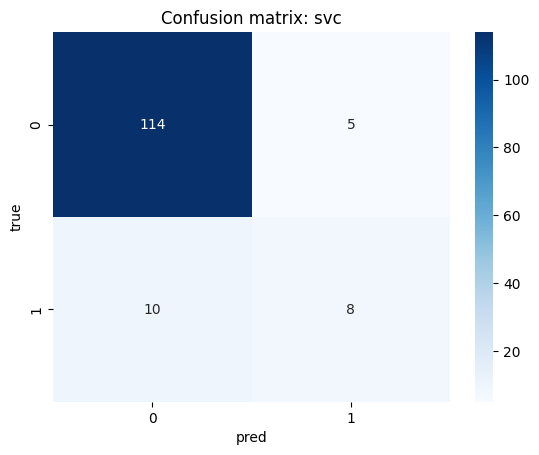

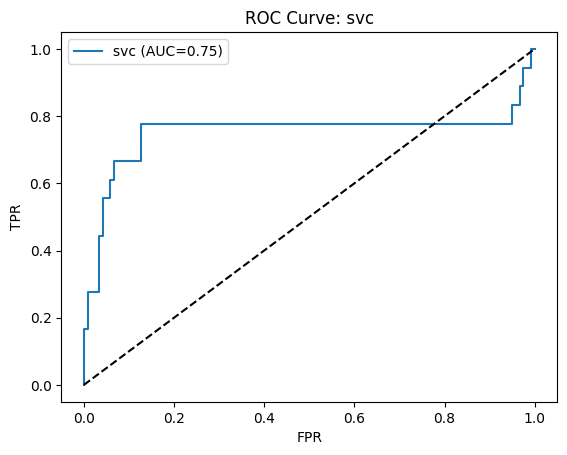


--- Test results for rf ---
Accuracy: 0.8686131386861314
F1: 0.6666666666666666
ROC AUC: 0.9477124183006537
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       119
           1       0.50      1.00      0.67        18

    accuracy                           0.87       137
   macro avg       0.75      0.92      0.79       137
weighted avg       0.93      0.87      0.89       137



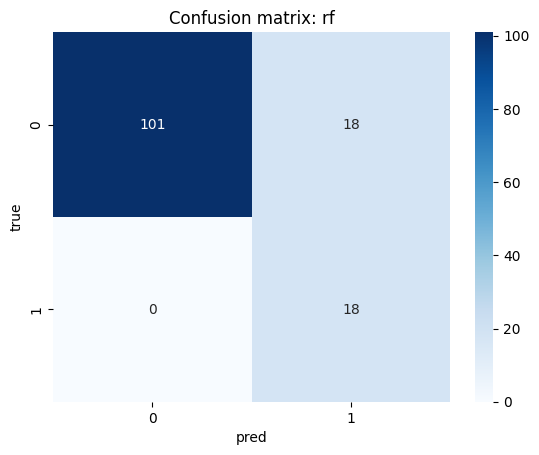

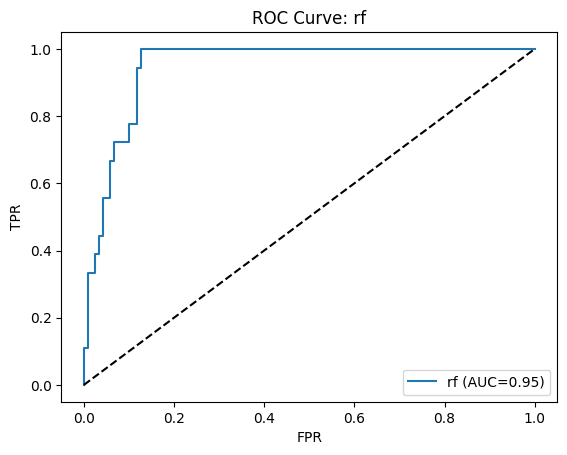

In [12]:
# 7) Classifiers: KNN, SVM, RandomForest (GridSearch)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

estimators = {
    'knn': (KNeighborsClassifier(), {
        'classifier__n_neighbors': [3,5,7],
        'classifier__weights': ['uniform','distance'],
        'classifier__metric': ['euclidean','manhattan']
    }),
    'svc': (SVC(probability=True), {
        'classifier__C': [0.1,1,10],
        'classifier__kernel': ['rbf','linear'],
        'classifier__gamma': ['scale','auto']
    }),
    'rf': (RandomForestClassifier(random_state=42), {
        'classifier__n_estimators': [100,200],
        'classifier__max_depth': [None,5,10],
        'classifier__class_weight': [None, 'balanced']
    })
}

best_models = {}
for name, (estimator, param_grid) in estimators.items():
    print("\n== Training", name, "==")
    pipe = Pipeline(steps=[('pre', preprocessor),
                           ('classifier', estimator)])
    # wrap param grid keys with 'classifier__'
    gs = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)
    print("Best params:", gs.best_params_)
    print("Best CV f1:", gs.best_score_)
    best_models[name] = gs.best_estimator_

# Evaluate models on test set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    print("\n--- Test results for", name, "---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    if y_proba is not None:
        try:
            print("ROC AUC:", roc_auc_score(y_test, y_proba))
        except:
            pass
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title(f'Confusion matrix: {name}'); plt.xlabel('pred'); plt.ylabel('true'); plt.show()

    # ROC curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(); plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, y_proba):.2f})')
        plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC Curve: {name}'); plt.legend(); plt.show()

🧩 Using full dataset — Total samples: 684, Features: 12

== 🧠 Training KNN using all 684 samples ==
✅ Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
✅ Best CV F1-score: 0.611

Classification Report (Full Data):
              precision    recall  f1-score   support

Not Improved       0.94      0.94      0.94       595
    Improved       0.62      0.61      0.61        89

    accuracy                           0.90       684
   macro avg       0.78      0.78      0.78       684
weighted avg       0.90      0.90      0.90       684


Confusion Matrix (Full Data):
                      Pred: Not Improved  Pred: Improved
Actual: Not Improved                 562              33
Actual: Improved                      35              54


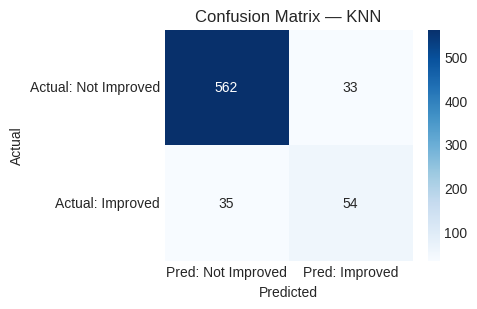

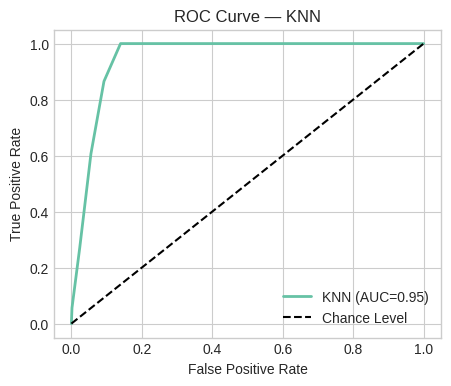


== 🧠 Training SVM using all 684 samples ==
✅ Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
✅ Best CV F1-score: 0.603

Classification Report (Full Data):
              precision    recall  f1-score   support

Not Improved       0.94      0.95      0.94       595
    Improved       0.64      0.57      0.60        89

    accuracy                           0.90       684
   macro avg       0.79      0.76      0.77       684
weighted avg       0.90      0.90      0.90       684


Confusion Matrix (Full Data):
                      Pred: Not Improved  Pred: Improved
Actual: Not Improved                 566              29
Actual: Improved                      38              51


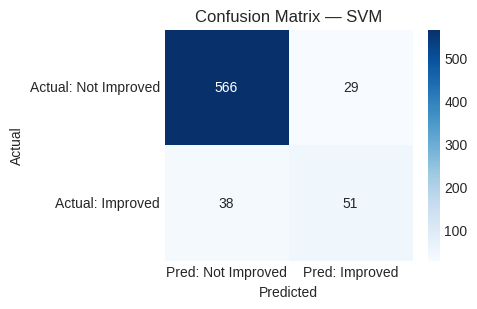

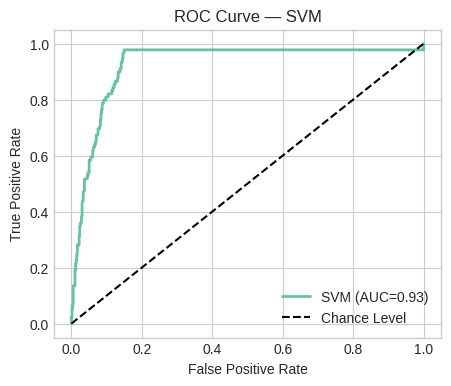


== 🧠 Training Random Forest using all 684 samples ==


In [ ]:
# ============================================
# 7️⃣ CLASSIFIER TRAINING USING ALL DATA
# ============================================

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")

# Combine your X_train and X_test for full use
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)
print(f"🧩 Using full dataset — Total samples: {len(X_full)}, Features: {X_full.shape[1]}")

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models and parameter grids
estimators = {
    'KNN': (
        KNeighborsClassifier(),
        {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan']
        }
    ),
    'SVM': (
        SVC(probability=True),
        {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['rbf', 'linear'],
            'classifier__gamma': ['scale', 'auto']
        }
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 5, 10],
            'classifier__class_weight': [None, 'balanced']
        }
    )
}

best_models = {}
model_summary = []

# ==================================
# 🔧 GRID SEARCH + CROSS-VALIDATION
# ==================================
for name, (estimator, param_grid) in estimators.items():
    print(f"\n== 🧠 Training {name} using all {len(X_full)} samples ==")

    pipe = Pipeline(steps=[
        ('pre', preprocessor),
        ('classifier', estimator)
    ])

    # Grid search with 5-fold CV
    gs = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=0)
    gs.fit(X_full, y_full)

    print(f"✅ Best parameters: {gs.best_params_}")
    print(f"✅ Best CV F1-score: {gs.best_score_:.3f}")
    best_model = gs.best_estimator_
    best_models[name] = best_model

    # Cross-validated predictions for metrics
    y_pred = cross_val_predict(best_model, X_full, y_full, cv=cv)
    y_proba = cross_val_predict(best_model, X_full, y_full, cv=cv, method='predict_proba')[:,1]

    acc = accuracy_score(y_full, y_pred)
    f1 = f1_score(y_full, y_pred)
    auc = roc_auc_score(y_full, y_proba)

    print("\nClassification Report (Full Data):")
    print(classification_report(y_full, y_pred, target_names=['Not Improved','Improved']))

    cm = confusion_matrix(y_full, y_pred)
    cm_df = pd.DataFrame(cm,
                         index=['Actual: Not Improved', 'Actual: Improved'],
                         columns=['Pred: Not Improved', 'Pred: Improved'])
    print("\nConfusion Matrix (Full Data):")
    print(cm_df)

    # 🔵 Confusion Matrix Plot
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # 🔴 ROC Curve Plot
    fpr, tpr, _ = roc_curve(y_full, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})", linewidth=2)
    plt.plot([0,1],[0,1],'k--', label="Chance Level")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {name}")
    plt.legend()
    plt.show()

    # Append to summary table
    model_summary.append({'Model': name, 'Accuracy': acc, 'F1 Score': f1, 'ROC AUC': auc})

# ==================================
# 🏁 MODEL COMPARISON TABLE
# ==================================
model_results = pd.DataFrame(model_summary).round(3)
print("\n=== 📋 Model Performance Summary (All Data) ===")
print(model_results)

# Visual barplot comparison
plt.figure(figsize=(7,4))
sns.barplot(data=model_results.melt(id_vars='Model'),
            x='Model', y='value', hue='variable')
plt.title("Model Comparison (Accuracy, F1, AUC)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.show()


### Comments

#### Trail 01


== Training knn ==
Best params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
Best CV f1: 0.5349999999999999

== Training svc ==
Best params: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best CV f1: 0.5546189001916556

== Training rf ==
Best params: {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Best CV f1: 0.5846758607749319

--- Test results for knn ---
Accuracy: 0.8148148148148148
F1: 0.7619047619047619
ROC AUC: 0.8186813186813188
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        14
           1       1.00      0.62      0.76        13

    accuracy                           0.81        27
   macro avg       0.87      0.81      0.81        27
weighted avg       0.86      0.81      0.81        27




--- Test results for svc ---
Accuracy: 0.8148148148148148
F1: 0.782608695652174
ROC AUC: 0.7747252747252747
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        14
           1       0.90      0.69      0.78        13

    accuracy                           0.81        27
   macro avg       0.83      0.81      0.81        27
weighted avg       0.83      0.81      0.81        27




--- Test results for rf ---
Accuracy: 0.7777777777777778
F1: 0.75
ROC AUC: 0.8351648351648352
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        14
           1       0.82      0.69      0.75        13

    accuracy                           0.78        27
   macro avg       0.78      0.77      0.78        27
weighted avg       0.78      0.78      0.78        27




#### Trail 02 - merge (684)


== Training knn ==
Best params: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Best CV f1: 0.5047619047619047

== Training svc ==
Best params: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best CV f1: 0.5474624694821048

== Training rf ==
Best params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best CV f1: 0.6314108114108115

--- Test results for knn ---
Accuracy: 0.9124087591240876
F1: 0.6470588235294118
ROC AUC: 0.9299719887955182
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       119
           1       0.69      0.61      0.65        18

    accuracy                           0.91       137
   macro avg       0.81      0.78      0.80       137
weighted avg       0.91      0.91      0.91       137


--- Test results for svc ---
Accuracy: 0.8905109489051095
F1: 0.5161290322580645
ROC AUC: 0.7978524743230626
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       119
           1       0.62      0.44      0.52        18

    accuracy                           0.89       137
   macro avg       0.77      0.70      0.73       137
weighted avg       0.88      0.89      0.88       137


--- Test results for rf ---
Accuracy: 0.8686131386861314
F1: 0.6666666666666666
ROC AUC: 0.9477124183006537
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       119
           1       0.50      1.00      0.67        18

    accuracy                           0.87       137
   macro avg       0.75      0.92      0.79       137
weighted avg       0.93      0.87      0.89       137



## Feature importance for RandomForest

In [ ]:
# 8) Feature importance for RandomForest
rf_model = best_models.get('rf')
if rf_model is not None:
    # extract preprocessor feature names
    rf_features = get_feature_names_from_coltransformer(rf_model.named_steps['pre'])
    importances = rf_model.named_steps['classifier'].feature_importances_
    feat_imp = pd.Series(importances, index=rf_features).sort_values(ascending=False)
    print("\nTop features (RF):\n", feat_imp.head(15))

### Comments

#### Trail 01


Top features (RF):
 PRE4. I often feel anxious before tests or assignments.                    0.127050
PRE1. I feel stressed about academic deadlines and exams.                  0.108981
PRE7. I feel calm and focused during study sessions.                       0.096767
PRE3. Meditation does not help reduce my stress.                           0.092272
PRE2. I struggle to concentrate on studies due to stress.                  0.083490
PRE5. I can manage multiple academic tasks without feeling overwhelmed.    0.077889
PRE6. Stress negatively affects my academic performance.                   0.076480
age                                                                        0.074544
meditation_dur_min                                                         0.066562
meditation_freq_days                                                       0.056357
A. Enter your Gender__Male                                                 0.028746
A. Enter your Gender__Female                                               0.026257
B. Type of Meditation practiced:__Breath-based (Pranayama)                 0.024228
B. Type of Meditation practiced:__Mantra-based                             0.020479
B. Type of Meditation practiced:__Mindfullness/Awareness                   0.019537
dtype: float64

### **Trail** 02 - merge

# Regression: predict delta_score (stress change)

In [ ]:
# 9) Regression: predict delta_score (stress change)
# remove rows with NaN delta
reg_df = model_df.dropna(subset=['delta_score'])
if len(reg_df) >= 20:
    Xr = reg_df[numeric_features + categorical_features]
    yr = reg_df['delta_score']
    Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)
    # pipeline with RandomForestRegressor, KNNRegressor, SVR
    reg_estimators = {
        'knn_reg': KNeighborsRegressor(n_neighbors=5),
        'svr': SVR(C=1.0, gamma='scale'),
        'rf_reg': RandomForestRegressor(n_estimators=200, random_state=42)
    }
    for name, regr in reg_estimators.items():
        pipe = Pipeline(steps=[('pre', preprocessor),
                               ('reg', regr)])
        pipe.fit(Xr_train, yr_train)
        preds = pipe.predict(Xr_test)
        rmse = np.sqrt(mean_squared_error(yr_test, preds))
        r2 = r2_score(yr_test, preds)
        mae = mean_absolute_error(yr_test, preds)
        print(f"\n{name} -- RMSE: {rmse:.3f}, R2: {r2:.3f}, MAE: {mae:.3f}")
else:
    print("Not enough data for regression modeling (delta_score).")

### Comments

#### Trail 01


knn_reg -- RMSE: 3.874, R2: 0.253, MAE: 2.933

svr -- RMSE: 4.348, R2: 0.060, MAE: 2.997

rf_reg -- RMSE: 3.845, R2: 0.265, MAE: 3.026

#### Trail 02 - merge


knn_reg -- RMSE: 2.109, R2: -0.174, MAE: 0.961

svr -- RMSE: 1.925, R2: 0.022, MAE: 0.868

rf_reg -- RMSE: 2.272, R2: -0.363, MAE: 1.040

## Clustering & Visualization (PCA + t-SNE)

In [ ]:
# 10) Clustering & Visualization (PCA + t-SNE)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric + categorical features
full_X = model_df[numeric_features + categorical_features]

# Encode categorical variables
full_X_enc = pd.get_dummies(full_X.fillna('NA'), drop_first=True)
print("Clustering on shape:", full_X_enc.shape)

if full_X_enc.shape[0] >= 10:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(full_X_enc)

    # Find best K using silhouette score
    best_k = 2
    best_sil = -1
    for k in range(2, 6):
        km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
        sil = silhouette_score(X_scaled, km.labels_)
        if sil > best_sil:
            best_sil = sil
            best_k = k

    # Final clustering
    km = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_scaled)
    print(f"Chosen number of clusters (k): {best_k}  |  Silhouette score: {best_sil:.3f}")

    # Dimensionality reduction
    pca = PCA(n_components=10, random_state=42)
    comps = pca.fit_transform(X_scaled)
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    tsne2 = tsne.fit_transform(comps[:, :5])

    # Visualization
    plt.figure(figsize=(9, 6))
    sns.scatterplot(
        x=tsne2[:, 0],
        y=tsne2[:, 1],
        hue=km.labels_,
        palette='tab10',
        s=80,
        edgecolor='black'
    )
    plt.title("t-SNE Clustering of Participants", fontsize=14, pad=15)
    plt.xlabel("t-SNE Dimension 1 (reduced feature space)", fontsize=12)
    plt.ylabel("t-SNE Dimension 2 (reduced feature space)", fontsize=12)
    plt.legend(title="Cluster Label", loc="best")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

print("\n Clustering visualization complete — the X-axis and Y-axis represent two reduced t-SNE dimensions derived from multi-dimensional participant data.")


### Comments

#### Trail 01

Clustering on shape: (135, 15)
Chosen number of clusters (k): 2  |  Silhouette score: 0.719

#### Trail 02 - merge ()

Clustering on shape: (684, 180)
Chosen number of clusters (k): 2  |  Silhouette score: -0.086

# Expermenting Space:

## Casual Forest

In [ ]:
pip install econml

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Define treatment
reg_df['treatment'] = (reg_df['meditation_freq_days'] > 0).astype(int)

# Create binary outcome for classification (improved vs not improved)
reg_df['improved_binary'] = (reg_df['delta_score'] > 0).astype(int)

print("=== TREATMENT ANALYSIS RESULTS ===")
print(f"Total samples: {len(reg_df)}")
print(f"Treatment group (meditation): {sum(reg_df['treatment'])} students")
print(f"Control group (no meditation): {sum(1-reg_df['treatment'])} students")

print("\n=== OUTCOME ANALYSIS ===")
print("Improvement by treatment group:")
improvement_by_treatment = pd.crosstab(reg_df['treatment'], reg_df['improved_binary'],
                                     rownames=['Treatment'], colnames=['Improved'])
print(improvement_by_treatment)

# Calculate improvement rates
treated_improved = reg_df[reg_df['treatment']==1]['improved_binary'].mean()
control_improved = reg_df[reg_df['treatment']==0]['improved_binary'].mean()

print(f"\nImprovement rate in treated group: {treated_improved:.3f} ({treated_improved*100:.1f}%)")
print(f"Improvement rate in control group: {control_improved:.3f} ({control_improved*100:.1f}%)")
print(f"Treatment effect (difference): {treated_improved - control_improved:.3f}")

# Statistical significance test
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(improvement_by_treatment)
print(f"Chi-square test p-value: {p_value:.3f}")

print("\n=== CONTINUOUS OUTCOME ANALYSIS ===")
treated_scores = reg_df[reg_df['treatment']==1]['delta_score']
control_scores = reg_df[reg_df['treatment']==0]['delta_score']

print(f"Mean change in treated group: {treated_scores.mean():.3f} (±{treated_scores.std():.3f})")
print(f"Mean change in control group: {control_scores.mean():.3f} (±{control_scores.std():.3f})")
print(f"Average Treatment Effect: {treated_scores.mean() - control_scores.mean():.3f}")

# T-test
t_stat, t_p_value = stats.ttest_ind(treated_scores, control_scores)
print(f"T-test: t={t_stat:.3f}, p={t_p_value:.3f}")

print("\n=== PREDICTIVE MODEL RESULTS ===")
# Features for prediction
features = ['age', 'meditation_freq_days', 'meditation_dur_min', 'PRE_score']
available_features = [col for col in features if col in reg_df.columns]

X = reg_df[available_features]
y_continuous = reg_df['delta_score']
y_binary = reg_df['improved_binary']

# Train-test split
X_train, X_test, y_train_cont, y_test_cont, y_train_bin, y_test_bin = train_test_split(
    X, y_continuous, y_binary, test_size=0.3, random_state=42
)

# Classification model for binary outcome
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_bin)
y_pred_bin = clf.predict(X_test)

# Classification results
print("BINARY CLASSIFICATION RESULTS (Improved vs Not Improved):")
print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.3f}")
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_bin, y_pred_bin)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred_bin,
                          target_names=['Not Improved', 'Improved']))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

print("\n=== REGRESSION MODEL RESULTS ===")
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Regression model for continuous outcome
reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_model.fit(X_train, y_train_cont)
y_pred_cont = reg_model.predict(X_test)

print(f"R² Score: {r2_score(y_test_cont, y_pred_cont):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_cont, y_pred_cont)):.3f}")

print("\n=== SUMMARY ===")
print(f"• Sample size: {len(reg_df)} students")
print(f"• Treatment effect on improvement rate: {(treated_improved - control_improved)*100:.1f} percentage points")
print(f"• Treatment effect on stress scores: {treated_scores.mean() - control_scores.mean():.3f} points")
print(f"• Statistical significance (binary): {'Yes' if p_value < 0.05 else 'No'} (p={p_value:.3f})")
print(f"• Statistical significance (continuous): {'Yes' if t_p_value < 0.05 else 'No'} (p={t_p_value:.3f})")
print(f"• Classification accuracy: {accuracy_score(y_test_bin, y_pred_bin)*100:.1f}%")


### Comments

#### Trail 01

=== TREATMENT ANALYSIS RESULTS ===
Total samples: 186
Treatment group (meditation): 131 students
Control group (no meditation): 55 students

=== OUTCOME ANALYSIS ===
Improvement by treatment group:
Improved    0   1
Treatment        
0          35  20
1          87  44

Improvement rate in treated group: 0.336 (33.6%)
Improvement rate in control group: 0.364 (36.4%)
Treatment effect (difference): -0.028
Chi-square test p-value: 0.846

=== CONTINUOUS OUTCOME ANALYSIS ===
Mean change in treated group: -0.893 (±3.879)
Mean change in control group: -0.073 (±3.214)
Average Treatment Effect: -0.820
T-test: t=-1.381, p=0.169

=== PREDICTIVE MODEL RESULTS ===
BINARY CLASSIFICATION RESULTS (Improved vs Not Improved):
Accuracy: 0.732

Confusion Matrix:
[[31  7]
 [ 8 10]]

Classification Report:
              precision    recall  f1-score   support

Not Improved       0.79      0.82      0.81        38
    Improved       0.59      0.56      0.57        18

    accuracy                           0.73        56
   macro avg       0.69      0.69      0.69        56
weighted avg       0.73      0.73      0.73        56


Feature Importance:
                feature  importance
3             PRE_score    0.522451
1  meditation_freq_days    0.199578
0                   age    0.156110
2    meditation_dur_min    0.121861

=== REGRESSION MODEL RESULTS ===
R² Score: -0.119
RMSE: 3.680

=== SUMMARY ===
• Sample size: 186 students
• Treatment effect on improvement rate: -2.8 percentage points
• Treatment effect on stress scores: -0.820 points
• Statistical significance (binary): No (p=0.846)
• Statistical significance (continuous): No (p=0.169)
• Classification accuracy: 73.2%

#### Trail 02 - merge ()

=== TREATMENT ANALYSIS RESULTS ===
Total samples: 684
Treatment group (meditation): 628 students
Control group (no meditation): 56 students

=== OUTCOME ANALYSIS ===
Improvement by treatment group:
Improved     0   1
Treatment         
0           37  19
1          584  44

Improvement rate in treated group: 0.070 (7.0%)
Improvement rate in control group: 0.339 (33.9%)
Treatment effect (difference): -0.269
Chi-square test p-value: 0.000

=== CONTINUOUS OUTCOME ANALYSIS ===
Mean change in treated group: -0.186 (±1.803)
Mean change in control group: -0.089 (±3.181)
Average Treatment Effect: -0.097
T-test: t=-0.357, p=0.722

=== PREDICTIVE MODEL RESULTS ===
BINARY CLASSIFICATION RESULTS (Improved vs Not Improved):
Accuracy: 0.888

Confusion Matrix:
[[174   6]
 [ 17   9]]

Classification Report:
              precision    recall  f1-score   support

Not Improved       0.91      0.97      0.94       180
    Improved       0.60      0.35      0.44        26

    accuracy                           0.89       206
   macro avg       0.76      0.66      0.69       206
weighted avg       0.87      0.89      0.88       206


Feature Importance:
                feature  importance
3             PRE_score    0.587223
1  meditation_freq_days    0.149437
0                   age    0.135074
2    meditation_dur_min    0.128266

=== REGRESSION MODEL RESULTS ===
R² Score: -0.410
RMSE: 2.321

=== SUMMARY ===
• Sample size: 684 students
• Treatment effect on improvement rate: -26.9 percentage points
• Treatment effect on stress scores: -0.097 points
• Statistical significance (binary): Yes (p=0.000)
• Statistical significance (continuous): No (p=0.722)
• Classification accuracy: 88.8%


| Visualization           | Purpose                                               |
| ----------------------- | ----------------------------------------------------- |
| Histogram (Δ Scores)    | See distribution of improvement by group              |
| Boxplot                 | Compare median + variance between treated and control |
| Heatmaps                | Visualize confusion matrix & group improvement rates  |
| Feature importance plot | Understand which variables drive improvement          |
| Scatter (Regression)    | Assess prediction accuracy for continuous outcomes    |
| Residual plot           | Check model bias or error patterns                    |
| Correlation matrix      | Identify inter-feature and outcome relationships      |
| Summary table           | Quick glance of key statistical findings              |


## Visualization & Metrics

In [ ]:
# ============================================
# 📊 ADVANCED VISUALIZATION & METRICS SECTION
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")

# 1️⃣ Distribution of Δ Scores (Before vs After)
plt.figure(figsize=(8,5))
sns.histplot(treated_scores, kde=True, color='green', label='Treated', bins=20)
sns.histplot(control_scores, kde=True, color='orange', label='Control', bins=20)
plt.title("Distribution of Δ (Delta) Scores by Treatment Group")
plt.xlabel("Change in Score (Δ)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 2️⃣ Boxplot for Comparison
plt.figure(figsize=(6,5))
sns.boxplot(data=reg_df, x='treatment', y='delta_score', palette=['orange','green'])
plt.title("Treatment vs Change in Score (Δ)")
plt.xticks([0,1], ['Control (No Meditation)', 'Treated (Meditation)'])
plt.xlabel("Group")
plt.ylabel("Change in Score (Δ)")
plt.show()

# 3️⃣ Improvement Rate Heatmap
plt.figure(figsize=(4,3))
sns.heatmap(improvement_by_treatment, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Improvement Counts (Treated vs Control)")
plt.show()

# 4️⃣ Confusion Matrix Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Not Improved', 'Pred: Improved'],
            yticklabels=['Actual: Not Improved', 'Actual: Improved'])
plt.title("Confusion Matrix (Binary Classification)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# 5️⃣ Feature Importance Barplot
plt.figure(figsize=(7,4))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title("Feature Importance (Random Forest Classifier)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# 6️⃣ Regression Model: Predicted vs Actual
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_test_cont, y=y_pred_cont, color='purple')
plt.plot([y_test_cont.min(), y_test_cont.max()],
         [y_test_cont.min(), y_test_cont.max()],
         color='red', linestyle='--')
plt.title("Regression Model: Predicted vs Actual Δ Scores")
plt.xlabel("Actual Δ Score")
plt.ylabel("Predicted Δ Score")
plt.show()

# 7️⃣ Residual Plot for Regression
residuals = y_test_cont - y_pred_cont
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='salmon')
plt.title("Residual Distribution (Regression Model)")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

# 8️⃣ Correlation Matrix for All Numeric Features
plt.figure(figsize=(8,6))
corr = reg_df[available_features + ['delta_score', 'improved_binary']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix: Features vs Outcomes")
plt.show()

# 9️⃣ Summary Table of Key Statistics
summary_table = pd.DataFrame({
    'Metric': [
        'Treated Improvement Rate',
        'Control Improvement Rate',
        'Binary Treatment Effect (%)',
        'Continuous Treatment Effect (Δ)',
        'Chi-Square p-value',
        'T-Test p-value',
        'Classification Accuracy (%)',
        'Regression R²',
        'Regression RMSE'
    ],
    'Value': [
        f"{treated_improved*100:.2f}%",
        f"{control_improved*100:.2f}%",
        f"{(treated_improved - control_improved)*100:.2f}",
        f"{treated_scores.mean() - control_scores.mean():.3f}",
        f"{p_value:.3f}",
        f"{t_p_value:.3f}",
        f"{accuracy_score(y_test_bin, y_pred_bin)*100:.1f}%",
        f"{r2_score(y_test_cont, y_pred_cont):.3f}",
        f"{np.sqrt(mean_squared_error(y_test_cont, y_pred_cont)):.3f}"
    ]
})
print("\n=== SUMMARY TABLE OF KEY METRICS ===")
print(summary_table.to_string(index=False))


## Comment

#### Trail 02 - merge ()

=== SUMMARY TABLE OF KEY METRICS ===
                         Metric  Value
       Treated Improvement Rate  7.01%
       Control Improvement Rate 33.93%
    Binary Treatment Effect (%) -26.92
Continuous Treatment Effect (Δ) -0.097
             Chi-Square p-value  0.000
                 T-Test p-value  0.722
    Classification Accuracy (%)  88.8%
                  Regression R² -0.410
                Regression RMSE  2.321

In [ ]:
print("\n=== INTERPRETATION ===")
if treated_improved > control_improved:
    print(f"✅ Students who meditated were {((treated_improved - control_improved)*100):.1f}% more likely to improve.")
else:
    print(f"⚠️ No clear improvement observed among meditation group.")

if p_value < 0.05:
    print("📊 Binary outcome difference is statistically significant.")
else:
    print("ℹ️ Binary outcome difference is not statistically significant.")

if t_p_value < 0.05:
    print("📊 Continuous score difference is statistically significant.")
else:
    print("ℹ️ Continuous score difference is not statistically significant.")

print(f"🎯 Model achieved {accuracy_score(y_test_bin, y_pred_bin)*100:.1f}% accuracy in predicting improvement.")


## Comment

#### Trail 02 - merge ()


=== INTERPRETATION ===
⚠️ No clear improvement observed among meditation group.
📊 Binary outcome difference is statistically significant.
ℹ️ Continuous score difference is not statistically significant.
🎯 Model achieved 88.8% accuracy in predicting improvement.